# Thief Detector
## This task tests your Image Processing skills to build a motion detection algorithm that alarms you when you have an unwanted visitor in your home.

## Steps
- 1. Get the live video feed from your webcam
- 2. Fix a scene (the place you want to monitor) and store it as a reference background image
    - Store the first frame as the reference background frame
- 3. For every frame, check if there is any unwanted object inside the scene you are monitoring
    - Use **Background Subtraction** concept (**cv2.absdiff( )**)
        - Subtract the current frame from the reference background image(frame) to see the changes in the scene
        - If there is enormous amount of pixels distrubed in the subtraction result image
            - unwanted visitor (place is unsafe --> alarm the authorities)
        - If there is no enormous amount of pixels distrubed in the subtraction result image
            - no unwanted visitor (place is safe)
- 4. Output the text **"UNSAFE"** in **red** color on the top right of the frame when there is an intruder in the scene.
- 5. Save the live feed
- 6. Submit the (.ipynb) file

## Get live video feed from webcam [10 points]

In [71]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def record_video(filename='recorded_video.webm', duration=5):
  js = Javascript('''
    async function recordVideo(quality, duration_seconds) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const options = { mimeType: 'video/webm; codecs=vp9' };
      const recordedChunks = [];
      const mediaRecorder = new MediaRecorder(stream, options);

      mediaRecorder.ondataavailable = (event) => {
        if (event.data.size > 0) {
          recordedChunks.push(event.data);
        }
      };

      mediaRecorder.start();
      await new Promise(resolve => setTimeout(resolve, duration_seconds * 1000));
      mediaRecorder.stop();

      await new Promise(resolve => mediaRecorder.onstop = resolve);

      stream.getTracks().forEach(track => track.stop());
      div.remove();

      const blob = new Blob(recordedChunks, { type: 'video/webm' });
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      return new Promise(resolve => {
        reader.onloadend = () => {
          resolve(reader.result);
        };
      });
    }
    ''')

  display(js)
  data = eval_js('recordVideo({}, {})'.format(0.8, duration))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
# Call the function to record a 10-second video again
try:
  video_filename = record_video(filename='recorded_video.webm', duration=10)
  print(f'New video saved to {video_filename}')
except Exception as err:
  print(str(err))



<IPython.core.display.Javascript object>

New video saved to recorded_video.webm


## Read first frame, convert to Grayscale and store it as reference background image [10 points]

In [72]:
import cv2

# Open the video file
cap = cv2.VideoCapture('recorded_video.webm')

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    gray_first_frame = None
else:
    # Read the first frame
    ret, first_frame = cap.read()

    if ret:
        # Convert the first frame to grayscale
        gray_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur to smooth the image and reduce noise
        gray_first_frame = cv2.GaussianBlur(gray_first_frame, (21, 21), 0)

        print("First frame read from video, converted to grayscale, and blurred for background reference.")

        # Save the grayscale first frame for verification (optional)
        cv2.imwrite('gray_first_frame.jpg', gray_first_frame)

    else:
        print("Error: Could not read the first frame from the video.")
        gray_first_frame = None

    # Release the video capture object
    cap.release()


First frame read from video, converted to grayscale, and blurred for background reference.


## Compute Absolute Difference between Current and First frame [20 points]

In [73]:
import cv2
import numpy as np

# Re-open the video file to process all frames
cap = cv2.VideoCapture('recorded_video.webm')

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Starting background subtraction...")
    # List to store processed frames (optional, for later display or saving)
    processed_frames = []

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break # End of video

        # Convert current frame to grayscale and apply Gaussian blur
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)

        # Compute the absolute difference between the first frame and the current frame

        if 'gray_first_frame' in locals() and gray_first_frame is not None:
            frame_diff = cv2.absdiff(gray_first_frame, gray_frame)
            # For demonstration, let's store one of the difference frames
            if frame_count == 10:
                example_diff_frame = frame_diff
                print("Example difference frame captured.")

            # You would typically continue processing 'frame_diff' here (e.g., thresholding, contour finding)
            # For now, we'll just acknowledge its computation.
            # print(f"Processed frame {frame_count} - computed absolute difference.")
            processed_frames.append(frame_diff) # Append for later processing if needed

        frame_count += 1

    print(f"Finished processing {frame_count} frames.")

    # Release the video capture object
    cap.release()

    # Display the example difference frame if captured
    if 'example_diff_frame' in locals() and example_diff_frame is not None:

        cv2.imwrite('example_frame_diff.jpg', example_diff_frame)
        print("Saved an example difference frame as 'example_frame_diff.jpg'.")
    else:
        print("No example difference frame captured (perhaps video was too short or gray_first_frame was missing).")


Starting background subtraction...
Example difference frame captured.
Finished processing 311 frames.
Saved an example difference frame as 'example_frame_diff.jpg'.


## Apply threshold [5 points]

In [74]:
import cv2
import numpy as np

# Re-open the video file to process all frames for thresholding
cap = cv2.VideoCapture('recorded_video.webm')

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Applying threshold to difference frames...")
    # List to store thresholded frames
    thresholded_frames = []

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break # End of video

        # Convert current frame to grayscale and apply Gaussian blur
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)

        # Ensure gray_first_frame is available from previous execution
        if 'gray_first_frame' in locals() and gray_first_frame is not None:
            # Compute the absolute difference
            frame_diff = cv2.absdiff(gray_first_frame, gray_frame)

            # Apply threshold to the difference image

            _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

            # Dilate the thresholded image to fill in holes and connect regions

            thresh = cv2.dilate(thresh, None, iterations=2)


            if frame_count == 15: # Example: store the 15th thresholded frame
                example_thresh_frame = thresh
                print("Example thresholded frame captured.")

            thresholded_frames.append(thresh) # Store for later use (e.g., contour finding)

        frame_count += 1

    print(f"Finished applying threshold to {frame_count} frames.")

    # Release the video capture object
    cap.release()

    # Display the example thresholded frame if captured
    if 'example_thresh_frame' in locals() and example_thresh_frame is not None:
        cv2.imwrite('example_thresholded_frame.jpg', example_thresh_frame)
        print("Saved an example thresholded frame as 'example_thresholded_frame.jpg'.")
    else:
        print("No example thresholded frame captured (perhaps video was too short or gray_first_frame was missing).")


Applying threshold to difference frames...
Example thresholded frame captured.
Finished applying threshold to 311 frames.
Saved an example thresholded frame as 'example_thresholded_frame.jpg'.


## Find contours [10 points]

Finding contours in thresholded frames...
Example frame with contours captured.
Finished finding contours for 311 frames.


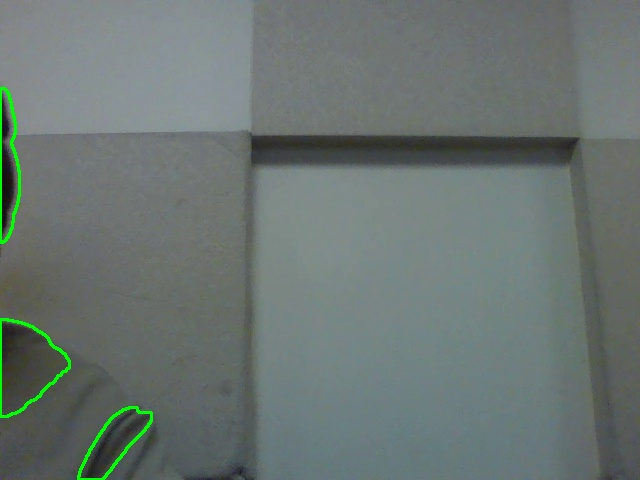

Saved an example frame with contours as 'example_frame_with_contours.jpg'.


In [75]:
import cv2
import numpy as np
from IPython.display import Image, display

# Re-open the video file to process all frames for contour finding
cap = cv2.VideoCapture('recorded_video.webm')

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Finding contours in thresholded frames...")

    # List to store frames with contours drawn (for demonstration/saving)
    frames_with_contours = []

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert current frame to grayscale and apply Gaussian blur
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)

        # Ensure gray_first_frame is available from previous execution
        if 'gray_first_frame' in locals() and gray_first_frame is not None:
            # Compute the absolute difference
            frame_diff = cv2.absdiff(gray_first_frame, gray_frame)

            # Apply threshold to the difference image
            _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

            # Dilate the thresholded image
            thresh = cv2.dilate(thresh, None, iterations=2)

            # Find contours on the thresholded image

            contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Store the current frame with contours for later processing (drawing rectangles, etc.)

            current_frame_with_contours = frame.copy()
            all_contours_for_frame = []

            for contour in contours:
                # Filter out small contours (noise) - adjust as needed
                if cv2.contourArea(contour) < 500: # Minimum area threshold
                    continue
                all_contours_for_frame.append(contour)





            frames_with_contours.append((frame.copy(), all_contours_for_frame))


            if frame_count == 20 and len(all_contours_for_frame) > 0:

                example_frame_display = frame.copy()
                cv2.drawContours(example_frame_display, all_contours_for_frame, -1, (0, 255, 0), 2)
                example_contours_frame = example_frame_display
                print("Example frame with contours captured.")

        frame_count += 1

    print(f"Finished finding contours for {frame_count} frames.")

    # Release the video capture object
    cap.release()

    # Display the example frame with contours if captured
    if 'example_contours_frame' in locals() and example_contours_frame is not None:
        cv2.imwrite('example_frame_with_contours.jpg', example_contours_frame)
        display(Image(filename='example_frame_with_contours.jpg'))
        print("Saved an example frame with contours as 'example_frame_with_contours.jpg'.")
    else:
        print("No significant contours found or video was too short to capture example.")

## Check if contourArea is large and draw rectangle around the object, output "UNSAFE" text in red color [30 points]

In [76]:
import cv2
import numpy as np
from IPython.display import HTML, display
from base64 import b64encode

# Re-open the video file to process all frames for motion detection
cap = cv2.VideoCapture('recorded_video.webm')

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Starting motion detection...")

    output_frames = [] # To store frames with annotations

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


    output_fps = 20.0

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break # End of video

        # Original frame to draw on
        annotated_frame = frame.copy()
        motion_detected = False

        # Convert current frame to grayscale and apply Gaussian blur
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)

        # Ensure gray_first_frame is available
        if 'gray_first_frame' in locals() and gray_first_frame is not None:
            # Compute the absolute difference
            frame_diff = cv2.absdiff(gray_first_frame, gray_frame)

            # Apply threshold to the difference image
            _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

            # Dilate the thresholded image
            thresh = cv2.dilate(thresh, None, iterations=2)

            # Find contours on the thresholded image
            contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:

                if cv2.contourArea(contour) < 500: # Minimum area threshold
                    continue

                # If a significant contour is found, its a theif
                motion_detected = True

                # Get bounding box for the contour and draw rectangle
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(annotated_frame, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green rectangle

            # If motion is detected, output "UNSAFE" text in red
            if motion_detected:
                text = "UNSAFE"
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 1
                font_thickness = 2
                text_color = (0, 0, 255) # Red color (BGR)
                text_color_bg = (0, 0, 0) # Black background for text

                # Get text size to place it nicely (top right corner)
                text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
                text_x = annotated_frame.shape[1] - text_size[0] - 10 # 10 pixels from right edge
                text_y = text_size[1] + 10 # 10 pixels from top edge

                # Draw background rectangle for text for better visibility
                cv2.rectangle(annotated_frame, (text_x - 5, text_y - text_size[1] - 5),
                              (text_x + text_size[0] + 5, text_y + 5), text_color_bg, -1)
                cv2.putText(annotated_frame, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

        output_frames.append(annotated_frame)

        frame_count += 1

    print(f"Finished processing {frame_count} frames for motion detection.")

    # Release video capture object
    cap.release()

   # Displaying the processed video
    # Save the output frames as a new video file
    output_filename = 'output_motion_detection.webm'
    if len(output_frames) > 0:
        # Ensure all frames have the same dimensions and type
        first_frame_dims = output_frames[0].shape

        # Creating a VideoWriter object using the determined output_fps
        fourcc = cv2.VideoWriter_fourcc(*'VP80') # WebM codec
        out = cv2.VideoWriter(output_filename, fourcc, output_fps, (first_frame_dims[1], first_frame_dims[0]))

        for frame in output_frames:
            out.write(frame)
        out.release()
        print(f"Processed video saved as '{output_filename}'.")

        # Embedding the video for display in Colab
        video_path = output_filename
        video_base64 = b64encode(open(video_path, 'rb').read()).decode('ascii')
        video_html = f"""<video controls src="data:video/webm;base64,{video_base64}" width="{frame_width}" height="{frame_height}"></video>"""
        display(HTML(video_html))

    else:
        print("No frames processed or captured to create an output video.")


Starting motion detection...
Finished processing 311 frames for motion detection.
Processed video saved as 'output_motion_detection.webm'.


## Display images [10 points]

Displaying key intermediate images:
--- gray_first_frame.jpg ---


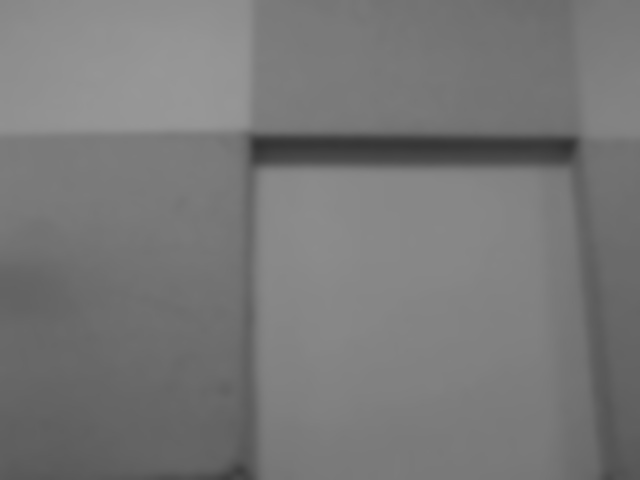

--- example_frame_diff.jpg ---


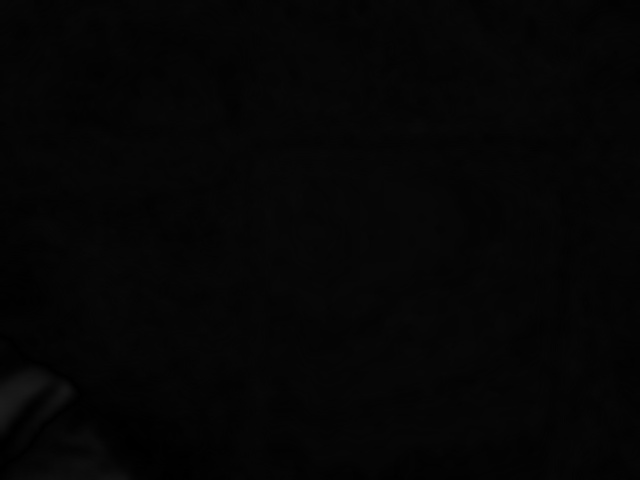

--- example_thresholded_frame.jpg ---


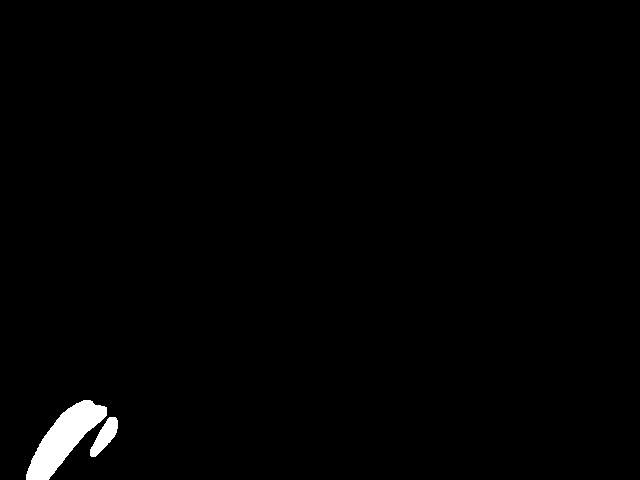

--- example_frame_with_contours.jpg ---


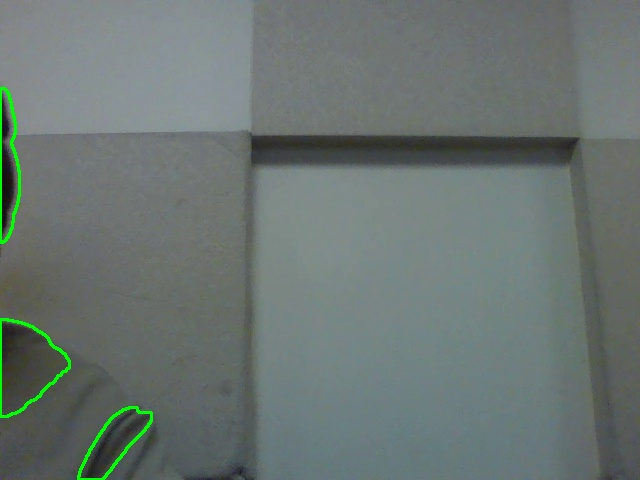

In [77]:
from IPython.display import Image, display
import os

print("Displaying key intermediate images:")

# List of image files to display
image_files = [
    'gray_first_frame.jpg',
    'example_frame_diff.jpg',
    'example_thresholded_frame.jpg',
    'example_frame_with_contours.jpg'
]

for img_file in image_files:
    if os.path.exists(img_file):
        print(f"--- {img_file} ---")
        display(Image(filename=img_file))
    else:
        print(f"--- {img_file} not found. Please ensure all previous cells were run successfully. ---")


## Release objects [5 points]

In [78]:
import cv2



# Check if 'cap' object exists and is open from previous steps
if 'cap' in locals() and isinstance(cap, cv2.VideoCapture) and cap.isOpened():
    cap.release()
    print("Released cv2.VideoCapture object (if it was active).")


if 'colab_cap' in locals() and hasattr(colab_cap, 'release'):
    colab_cap.release()
    print("Released ColabVideoCapture object (if it was active).")



print("All relevant video capture objects have been released.")

All relevant video capture objects have been released.
